# The script compares the output variables from standard Opensim offline workflow with the ones from the realtime calculations. This is done mainly by plotting ensemble curves and performing statistical analysis

In [2]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
#import sys
#sys.path.insert(0, os.path.abspath('D:\LocalDisk\Research\Opensim\RealTime\Scripts'))
import readMotionFile
import visualize
#os.chdir('D:\LocalDisk\Research\Opensim\RealTime\\results_rt\\results_rt\\')
cwd=os.getcwd()
cwd


'C:\\Users\\user\\Documents\\GitHub\\Compare_rt'

## Load the variables from real time
**Import the csv file of the filtered joint angles (ja_rt)**

In [31]:
os.chdir(cwd+'\\Data\\results_rt_TR_3') # chanhe working directory
ja_rt = pd.read_csv('q_filtered.csv')

Capture the knee flexion angle and transform it in degrees

In [32]:
data_rad = ja_rt['knee_angle_r']
time = ja_rt['time']
#print(time)
data_degrees = (data_rad*180)/np.pi

Plot the knee angle as degrees

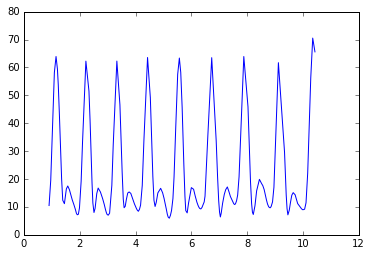

In [33]:
plt.plot(time,data_degrees*-1)

**Now load the joint moments (jm_rt)**

In [3]:
import opensim
model = opensim.Model(cwd+'\\Data\\Esther_Hamn.osim')
model.setUseVisualizer(True)
state = model.initSystem()
model.getVisualizer().show(state) # todo: run the IK solution in the visualizer


In [34]:
jm_rt = pd.read_csv('tau.csv')
jm_rt.head()

,time,pelvis_tilt,pelvis_list,pelvis_rotation,pelvis_tx,pelvis_ty,pelvis_tz,hip_flexion_r,hip_adduction_r,hip_rotation_r,...,pro_sup_r,wrist_flex_r,wrist_dev_r,arm_flex_l,arm_add_l,arm_rot_l,elbow_flex_l,pro_sup_l,wrist_flex_l,wrist_dev_l
0,0.90,3.80601,-109.08100,25.91790,-12.28850,-23.3508,17.262200,31.19390,-32.5240,14.07950,...,-0.007249,-0.034830,0.074835,2.263660,-2.165660,-0.162947,-1.95140,-0.056017,-0.124315,-0.208265
1,0.96,16.07250,62.57550,-3.57053,-9.78142,-43.7574,16.488000,41.12170,21.0171,7.56704,...,-0.017384,-0.042614,0.015789,1.557550,-2.463880,-0.229701,-1.76913,-0.056214,-0.147568,-0.186554
2,1.02,-3.10896,-77.94060,32.42640,33.46660,-13.8234,0.361226,6.98135,-95.2976,12.93760,...,-0.022391,-0.065396,-0.013471,0.923230,-2.324450,-0.229889,-1.34847,-0.043826,-0.129357,-0.124287
3,1.09,17.64220,8.84109,-6.15300,24.10360,-35.8054,6.110810,19.21670,35.4884,-19.44210,...,-0.035660,-0.028789,-0.065465,0.542534,-0.922586,-0.102834,-1.16123,-0.034683,-0.061931,-0.107000
4,1.15,18.66880,6.43449,13.12820,3.59835,-46.4173,14.478700,8.84451,-18.5754,11.43790,...,-0.027112,0.011121,-0.093665,-0.022048,-0.243190,-0.040329,-1.10010,-0.036075,-0.040002,-0.105458


Plot the knee moment

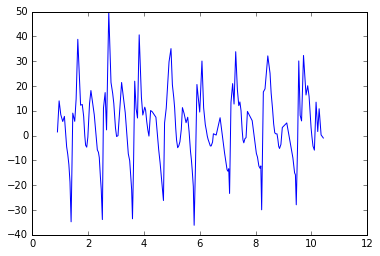

In [18]:
plt.plot(time,jm_rt.knee_angle_r)


Load the static optimization force results (sof) and plot the glut_med force

In [19]:
sof = pd.read_csv('so.csv')

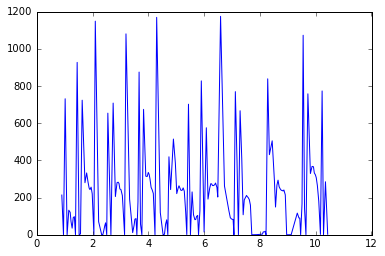

In [20]:
plt.plot(time,sof.glut_med1_r)

Load the joint reaction forces (jrf) results (sof) and plot the vertical hip contact force

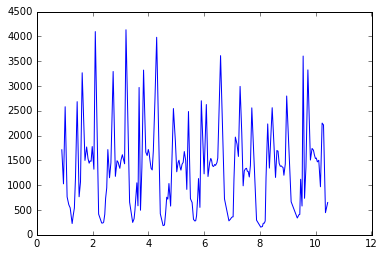

In [21]:
jrf = pd.read_csv('jr.csv')
plt.plot(time,jrf.hip_r_on_femur_r_in_ground_fy*-1)

# Now we load the offline data

In [22]:
os.chdir(cwd+'\\Data\\Offline\\')
header, labels, data = readMotionFile.read('TR_3_IK_Esther.mot')
index = labels.index('knee_angle_r')
data = array(data)
time = data[:,0]
print(time)

[  0.00000000e+00   1.00000000e-02   2.00000000e-02 ...,   1.05700000e+01
   1.05800000e+01   1.05900000e+01]


Plot the knee angle

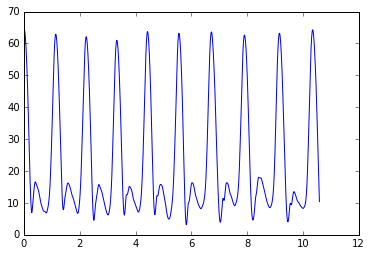

In [23]:
plt.plot(time,data[:,index]*-1)

In [25]:
header, labels, data = readMotionFile.read('TR_3_ID_Esther.sto')
index = labels.index('knee_angle_r_moment')
data = array(data)
time = data[:,0]

Plot the knee moment arm

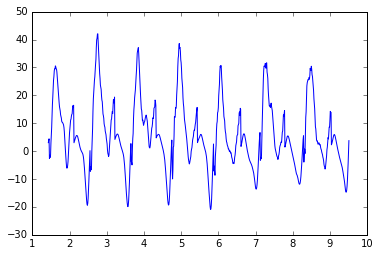

In [26]:
plt.plot(time,data[:,index])

# At this point we see that the time stamps of the two cases are very different to each other. Data are practically missing in the real time scenario, due to calculations lag. So we need some data interpolation techniques in order to perform statistical analysis later